Dans ce script, nous allons tester différents modèles de type convolutionnelsur le dataset 

résultat:
* l'utilisation des batchs rend l'inférence globale plus rapide
* un modèle a besoin de beaucoup de temps / parametres pour arriver à un certain niveau d'accuracy

In [1]:
import retinoto_py as fovea
n_val_stop = 4 * 2**10
args = fovea.Params(do_mask=False, n_val_stop=n_val_stop)
args

Welcome on macOS-26.1-arm64-arm-64bit-Mach-O	 user laurent	Running on MPS device (Apple Silicon/MacOS)	 - macos_version = 26.1	 with device mps, pytorch==2.9.1
Random seed 1998 has been set.


Params(image_size=224, do_mask=False, seed=1998, batch_size=64, num_workers=16, model_name='resnet101', do_scratch=False, num_epochs=50, n_train_stop=19200, n_val_stop=4096, lr=0.0001, delta1=0.05, delta2=0.001, weight_decay=0.0, shuffle=True, verbose=True)

# testing a ResNet model on the validation dataset

In [2]:
VAL_DATA_DIR = args.DATAROOT / 'Imagenet_full' / 'val'
val_loader, class_to_idx, idx_to_class = fovea.get_loader(args, VAL_DATA_DIR)
model = fovea.load_model(args)
model.eval()
print(f"Model {args.model_name} loaded.")

Downloading: "https://download.pytorch.org/models/resnet101-cd907fc2.pth" to /Users/laurent/.cache/torch/hub/checkpoints/resnet101-cd907fc2.pth


100%|██████████| 171M/171M [00:04<00:00, 36.8MB/s] 


Model resnet101 loaded.


# testing the role of batch_size on Wall Clock Time 

In [3]:
fname = '12_batch_size.json'
json_filename = args.data_cache / fname

%rm {json_filename}

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    for in_memory in [False, True]:
        batch_sizes = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048]
        pbar = fovea.tqdm(batch_sizes, desc='Testing Batch Sizes')
        val_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, VAL_DATA_DIR, in_memory=in_memory)
        for batch_size in pbar :
            pbar.set_postfix({'current_batch_size': batch_size, 'in_memory':in_memory})

            args = fovea.Params(batch_size=batch_size, n_val_stop=n_val_stop)
            val_loader = fovea.get_loader(args, val_dataset)
            model = fovea.load_model(args)
            tic = fovea.time.time()
            accuracy = fovea.get_validation_accuracy(args, model, val_loader)
            toc = fovea.time.time()
            this_result = {         
                            'batch_size': batch_size,
                            'in_memory': in_memory,
                            'accuracy': accuracy,
                            'wall_clock_time': toc-tic,
                            }
            all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)

Testing Batch Sizes:   0%|          | 0/11 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/2048 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/1024 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/512 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/256 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/128 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/64 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/32 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/16 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/8 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/4 [00:00<?, ?it/s]

Evaluating resnet101:   0%|          | 0/2 [00:00<?, ?it/s]

Testing Batch Sizes:   0%|          | 0/11 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/2048 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/1024 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/512 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/256 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/128 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/64 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/32 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/16 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/8 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/4 [00:00<?, ?it/s]

Loading dataset into memory...
Loaded 50000 images into memory


Evaluating resnet101:   0%|          | 0/2 [00:00<?, ?it/s]

In [4]:
results.T

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
batch_size,2,4,8,16,32,64,128,256,512,1024,...,4,8,16,32,64,128,256,512,1024,2048
in_memory,False,False,False,False,False,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
accuracy,0.809907,0.803902,0.805312,0.814446,0.80814,0.80024,0.798769,0.796186,0.807726,0.80332,...,0.800732,0.79654,0.798881,0.814196,0.797596,0.807055,0.805836,0.809896,0.8,0.796549
wall_clock_time,37.239082,28.206078,21.696232,18.882726,18.246691,18.002808,18.252242,19.482248,20.764862,23.526633,...,22.93276,15.732249,13.328834,12.827187,12.47316,12.858907,13.583899,15.27673,17.298425,20.842104


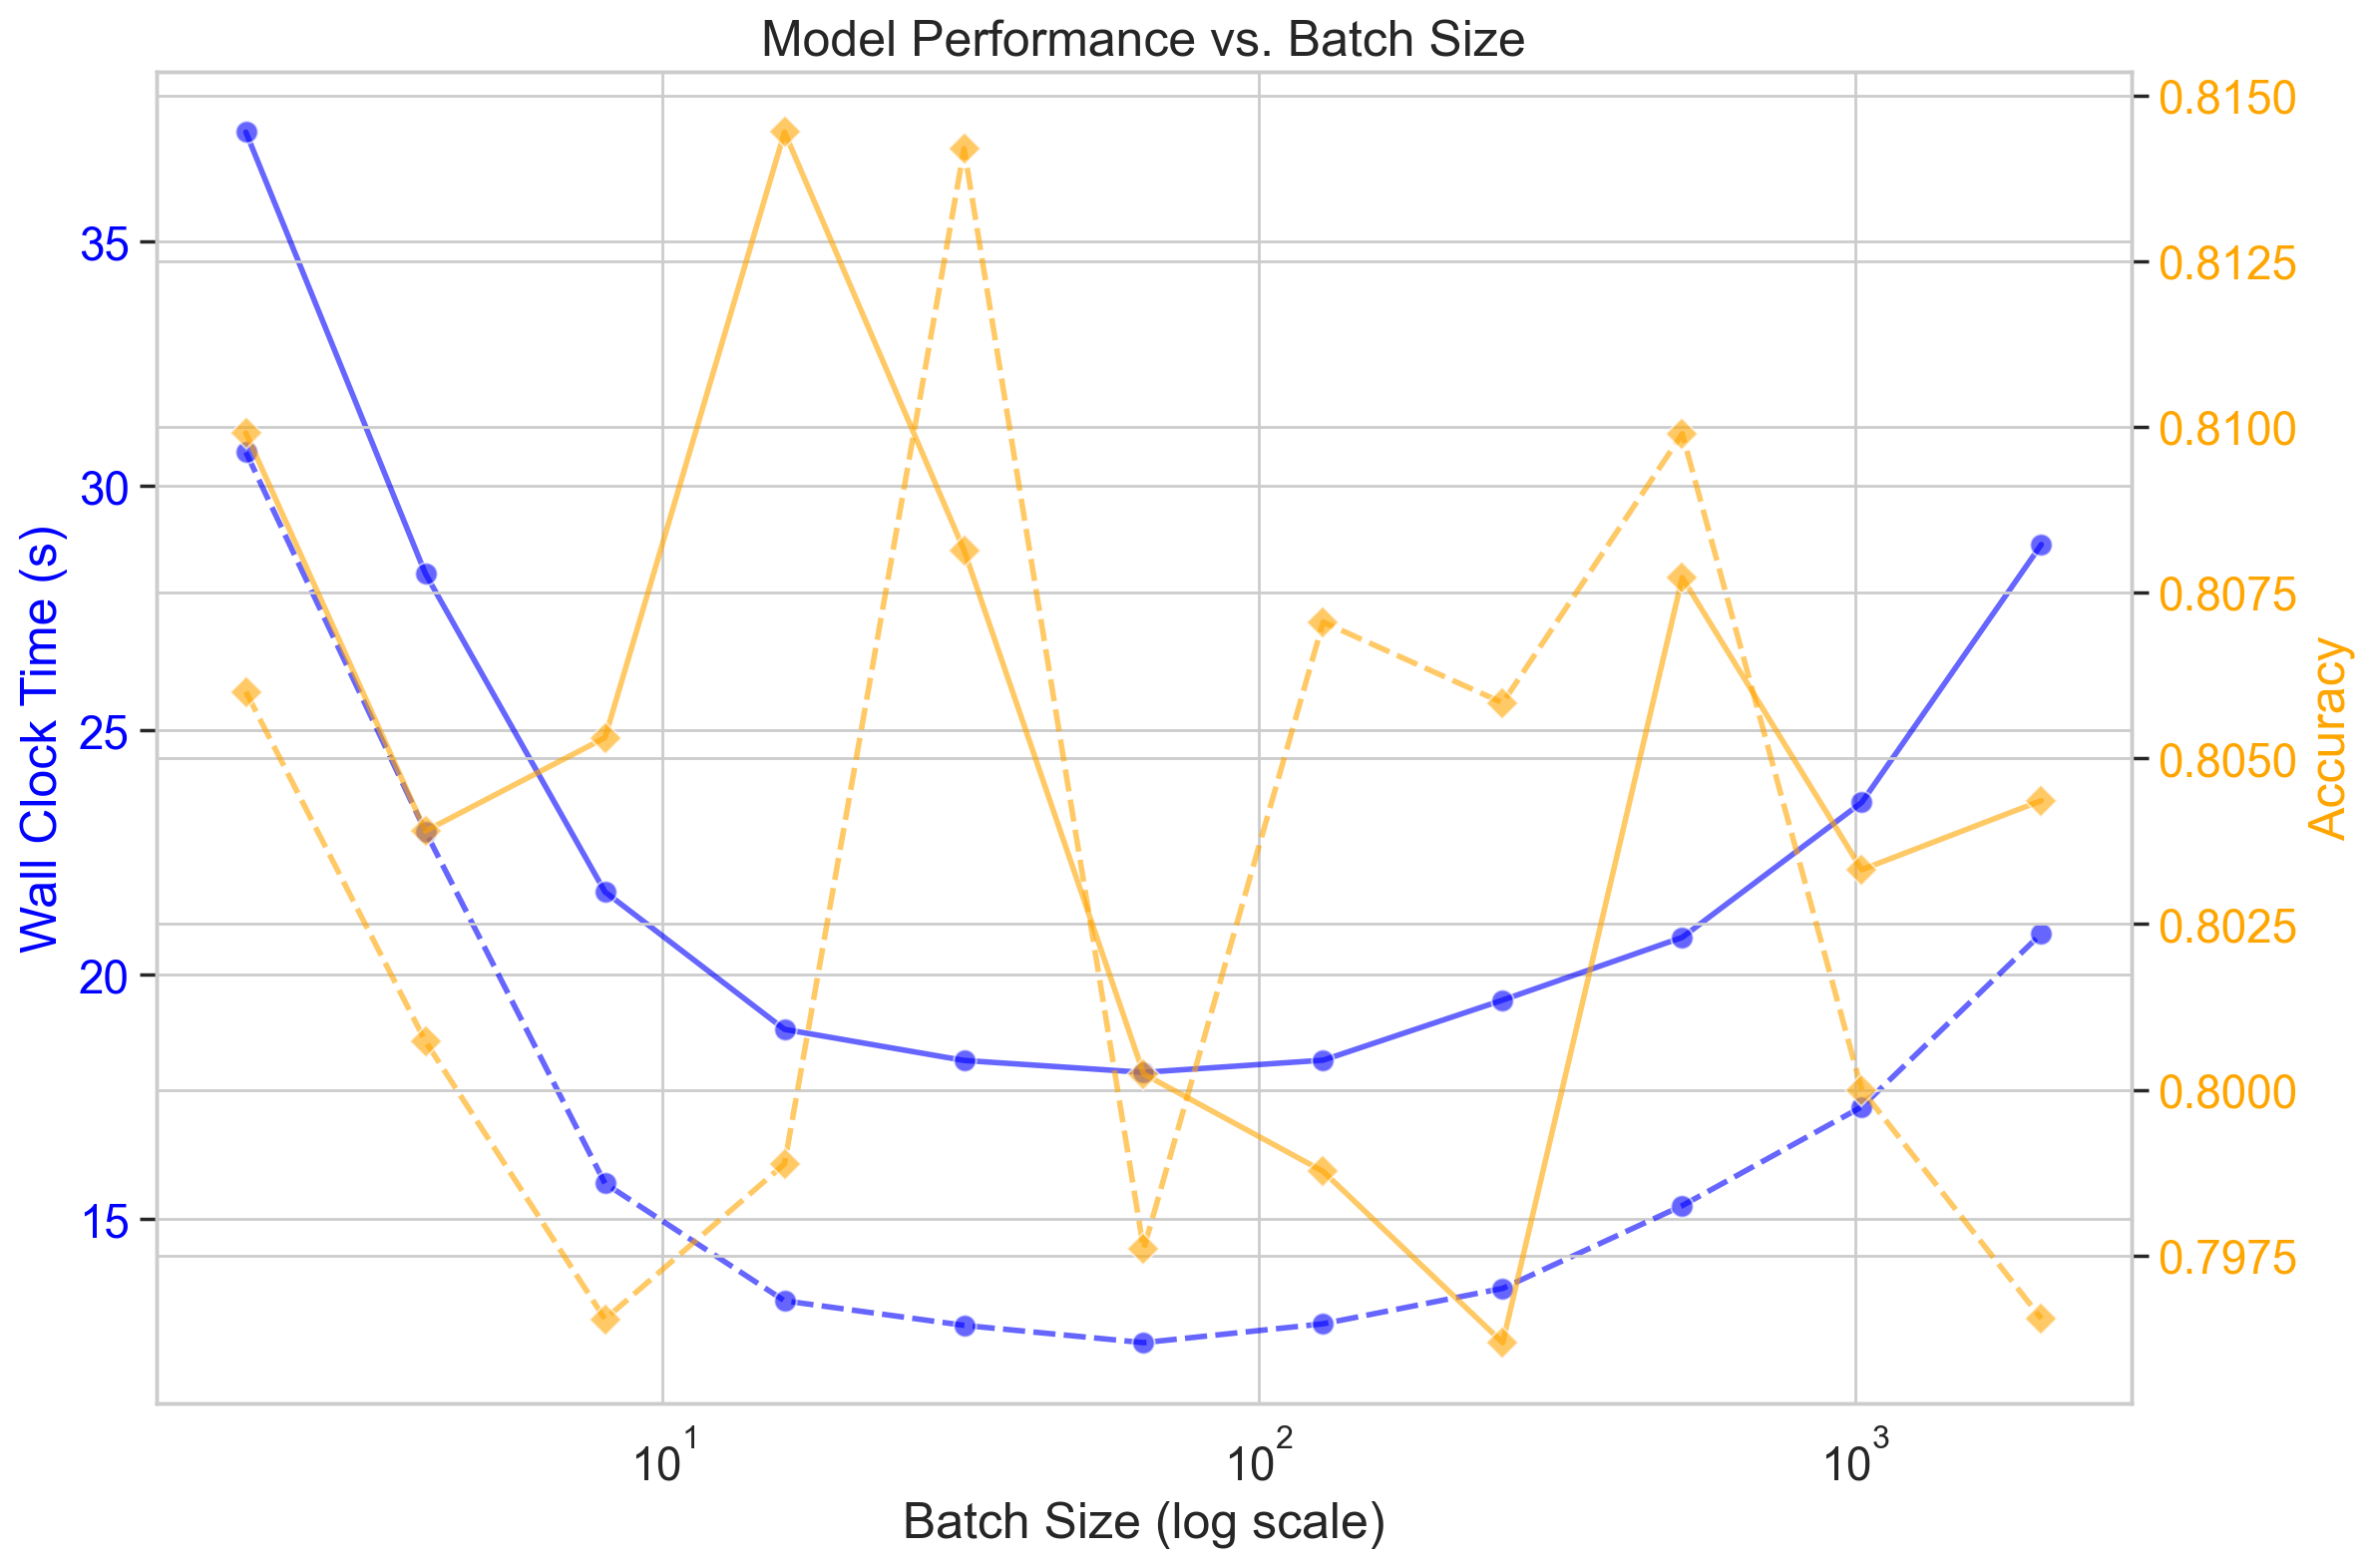

In [15]:
# --- Plot 1: Wall Clock Time (in Blue) ---
# Assign a label directly for legend creation
ax = fovea.sns.lineplot(
    data=results,
    x='batch_size',
    y='wall_clock_time',
    color='blue',                  # Set color to blue
    style='in_memory',          # Style by dataset
    marker='o',
    markersize=8,
    alpha=0.6,
    lw=2,
    label='Wall Clock Time (s)',   # Legend label for this line
    legend=False
)

# --- Plot 2: Accuracy (in Orange) ---
ax2 = ax.twinx()
fovea.sns.lineplot(
    data=results,
    x='batch_size',
    y='accuracy',
    color='orange',                # Set color to orange
    style='in_memory',          # Style by dataset
    marker='D',                    # Different marker for distinction
    markersize=8,
    alpha=0.6,
    lw=2,
    ax=ax2,                        # Plot on the secondary y-axis
    label='Accuracy',               # Legend label for this line
    legend=False
)

# --- Final Touches ---
# Set log scale for the x-axis
ax.set_xscale('log')

# Set axis labels and title
ax.set_xlabel('Batch Size (log scale)')
ax.set_ylabel('Wall Clock Time (s)', color='blue')
ax2.set_ylabel('Accuracy', color='orange')

# Match the tick colors to the lines for clarity
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')

# Set the main title
ax.set_title('Model Performance vs. Batch Size')

# # Create a single, unified legend
# # Get handles and labels from both axes
# h1, l1 = ax.get_legend_handles_labels()
# h2, l2 = ax2.get_legend_handles_labels()
# # Combine them and place the legend
# ax.legend('acc', 'time', loc='upper center', bbox_to_anchor=(0.25, 0.95), ncol=2)
# # ax.legend(h1 + h2, l1 + l2, loc='upper center', bbox_to_anchor=(0.25, 0.95), ncol=2)


# plt.tight_layout()
# Adjust layout to make space for the legend below the plot
fovea.plt.subplots_adjust(bottom=0.05) 
fovea.plt.show()

In [6]:
fovea.savefig(ax.get_figure(), name=fname, figures_folder=args.figures_folder, exts=['pdf'])    

# testing the role of `num_workers` on Wall Clock Time 

In [7]:
args.num_workers

16

In [8]:
fname = '12_num_workers.json'
json_filename = args.data_cache / fname

%rm {json_filename}

if json_filename.exists():
    results = fovea.pd.read_json(json_filename)
else:
    all_results = []
    pbar = fovea.tqdm([0, 1, 2, 4, 8, 16, 32], desc='num_workers')
    for in_memory in [False, True]:
        val_dataset, class_to_idx, idx_to_class = fovea.get_dataset(args, VAL_DATA_DIR, in_memory=in_memory)

        for num_workers in pbar:
            pbar.set_postfix({'num_workers': num_workers, 'in_memory':in_memory})
            args = fovea.Params(num_workers=num_workers, n_val_stop=n_val_stop)
            val_loader = fovea.get_loader(args, val_dataset)
            model = fovea.load_model(args)
            tic = fovea.time.time()
            accuracy = fovea.get_validation_accuracy(args, model, val_loader)
            toc = fovea.time.time()
            this_result = {         
                            'num_workers': num_workers,
                            'in_memory': in_memory,
                            'accuracy': accuracy,
                            'wall_clock_time': toc-tic,
                            }
            all_results.append(this_result)
    results = fovea.pd.DataFrame(all_results)
    results.to_json(json_filename, orient='records', indent=2)

rm: cached_data/12_num_workers.json: No such file or directory


num_workers:   0%|          | 0/7 [00:00<?, ?it/s]

AttributeError: module 'retinoto_py' has no attribute 'get_dataset'

In [ ]:
results.T

In [ ]:
# --- Plot 1: Wall Clock Time (in Blue) ---
# Assign a label directly for legend creation
ax = fovea.sns.lineplot(
    data=results,
    x='num_workers',
    y='wall_clock_time',
    color='blue',                  # Set color to blue
    marker='o',
    markersize=8,
    alpha=0.6,
    lw=2,
    label='Wall Clock Time (s)',   # Legend label for this line
    legend=False
)

# --- Plot 2: Accuracy (in Orange) ---
ax2 = ax.twinx()
fovea.sns.lineplot(
    data=results,
    x='num_workers',
    y='accuracy',
    color='orange',                # Set color to orange
    marker='D',                    # Different marker for distinction
    markersize=8,
    alpha=0.6,
    lw=2,
    ax=ax2,                        # Plot on the secondary y-axis
    label='Accuracy',               # Legend label for this line
    legend=False
)


# Set axis labels and title
ax.set_xlabel('Number of workers (num_workers)')
ax.set_ylabel('Wall Clock Time (s)', color='blue')
ax2.set_ylabel('Accuracy', color='orange')

# Match the tick colors to the lines for clarity
ax.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='orange')

# Set the main title
ax.set_title('Model Performance vs. num_workers')

# Create a single, unified legend
# Get handles and labels from both axes
h1, l1 = ax.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
# Combine them and place the legend
ax.legend(h1 + h2, l1 + l2, loc='upper center', bbox_to_anchor=(0.25, 0.95), ncol=2)


# plt.tight_layout()
# Adjust layout to make space for the legend below the plot
fovea.plt.subplots_adjust(bottom=0.05) 
fovea.plt.show()

In [ ]:
fovea.savefig(ax.get_figure(), name=fname, figures_folder=args.figures_folder, exts=['pdf'])    